# Week 4 - Partial Least Squares Regression

In [12]:
%matplotlib inline
import scipy as sp, numpy as np, sklearn as skl, pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.io import loadmat
from sklearn.preprocessing import scale
from sklearn import cross_validation
from sklearn.cross_decomposition import PLSRegression
import matplotlib.patches as mpatches
from sklearn.decomposition import PCA
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import r2_score

plt.style.use("ggplot")

data = loadmat('wk4_Cosgrove-data.mat', squeeze_me=True)['s']

X = data['X'].item() # the untransformed data matrix (66x102)
Y = data['Y'].item() # the untransformed LDH release at 48hours. (66x1)
phosphoproteins = data['phosphoproteins'].item() # names of phosphoproteins
conditions = data['conditions'].item() # cell array of the 66 conditions
drugList = data['drugList'].item() # description of the drugs used in each of the 66 conditions
drugListToxic = data['drugListToxic'].item() # binary value corresponding to whether drugList[i] is toxic
drugs = data['drugs'].item() # binary matrix mapping which measurements correspond to a drug treatment in drugList
cytokineList = data['cytokineList'].item() # cell array of cytokine treatments
ind4pProtein = data['ind4pProtein'].item() # column indices corresponding to measurements of 4 phosphoprotein subset

#### (1) Perform PLSR on the matrixes X and Y. How many principle components do you need for each to explain 90% of the variance? Discuss your findings.

Hint: Be sure to normalize each dataset as needed for the analysis.

In [16]:
# Rename PLS regression 
# Here we assign number of princle components and maximum iterations
PLS = PLSRegression(n_components = 4, scale=True, max_iter =1000) 

# We only want LDH release at 48 hours
Y48 = Y[:,4] 

#Scale values for X and Y
X_scaled = scale(X)
Y48_scaled = scale(Y48)

# Learn and apply the dimension reduction on the training data
xSc, ySc = PLS.fit_transform(X_scaled,Y48_scaled)

# Score X and Y48
R2Y = PLS.score(X_scaled,Y48_scaled)
print('R2Y value =', R2Y,'.')

R2Y value = 0.923198313534 .


I found that we needed to perform the PLSR with at least four principle components in order to explain 90% of the variance. This is indicated by our R2Y value of 0.923 when allowing for four components during the regression. When the number of principle compnents is set to three, for example, our R2Y equals 0.892, meaning that three components can only explain 89.2% of the variance. 

#### (2) Recreate the Figure S2A plot from Cosgrove et al. supplementary information. This is the PLSR scores plot (for PC1 and PC2), with toxic drugs colored according to the drug type and all other drugs are not colored. Use the drugList, drugListToxic to identify these categories.

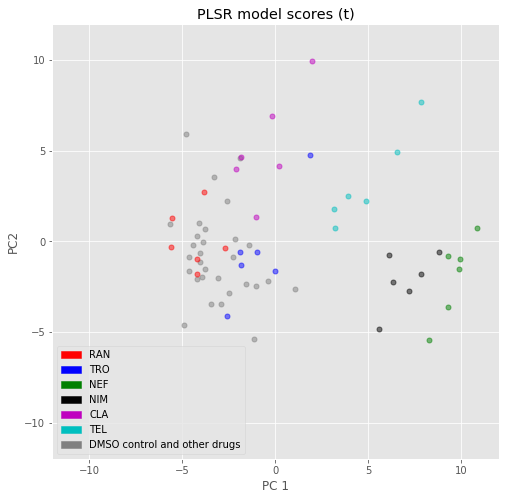

In [18]:
# Use the drugListToxic as a mask 
toxMask = drugListToxic
tox_iters = np.arange(11)[toxMask==1]
# We will have one color for each toxic drug
colors= ['r', 'b','g','k','m','c']
c_indx = -1

# Plot figure for different drug scores (PCs) one at a time
plt.figure(1, figsize=(8,8))
for indx in np.arange(drugs.shape[1]): # numbers between 0 and 10
    if indx not in tox_iters:
        C = 'gray'
        alph = 0.5
    else:
        c_indx += 1
        C = colors[c_indx]
    mask = drugs[:, indx]==1
    xVals = xSc[:,0]
    yVals = xSc[:,1]
    drugX = xVals[mask]
    drugY = yVals[mask]
    plt.plot(drugX, drugY, '.', markersize = 10, c=C, alpha = alph)
     
# Create legend for the color corresponding to each toxic drug
RANpatch = mpatches.Patch(color='r', label='RAN')
TROpatch = mpatches.Patch(color='b', label='TRO')
NEFpatch = mpatches.Patch(color='g', label='NEF')
NIMpatch = mpatches.Patch(color='k', label='NIM')
CLApatch = mpatches.Patch(color='m', label='CLA')
TELpatch = mpatches.Patch(color='c', label='TEL')
NONTOXICpatch = mpatches.Patch(color='gray', label='DMSO control and other drugs')

# Set x and y limits, show resulting graph
plt.legend(handles=[RANpatch,TROpatch,NEFpatch,NIMpatch,CLApatch,TELpatch,NONTOXICpatch])
plt.xlim(-12,12)
plt.ylim(-12,12)
plt.xlabel('PC 1')
plt.ylabel('PC2')
plt.title('PLSR model scores (t)')
plt.legend()
plt.show()

#### (3) Create the loadings plot corresponding to (2). Interpret the results shown on the plot.

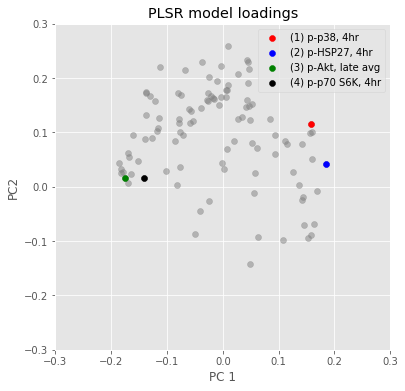

In [19]:
# Assign name to loadings plot
loadings = PLS.x_loadings_

# Graph x loadings for PC1 and PC2
plt.figure(2, figsize=(6,6))
plt.scatter(loadings[:,0], loadings[:,1], c='gray', alpha = alph)
plt.scatter(loadings[79,0], loadings[79,1], c='r', label = '(1) p-p38, 4hr')
plt.scatter(loadings[85,0], loadings[85,1], c='b', label='(2) p-HSP27, 4hr')
plt.scatter(loadings[34,0], loadings[34,1], c='g', label='(3) p-Akt, late avg')
plt.scatter(loadings[37,0], loadings[37,1], c='k',label='(4) p-p70 S6K, 4hr')
plt.xlim(-0.3,0.3)
plt.ylim(-0.3,0.3)
plt.xlabel('PC 1')
plt.ylabel('PC2')
plt.title('PLSR model loadings')
plt.legend()
plt.show()

This loadings plot indicates how much each measured parameter contributes to principle components 1 and 2. Points further away from zero will have a larger magnitude, and thus, a larger contribution. Points that are closer to the origin of (0,0) are considered to contribute less to the covariance between X and Y. For example, we see that data point 1 has positive values for both PC1 and PC2. This means that as we increase the value of this data point, both PC1 and PC2 will increase. 

#### (4) Recreate a 4-principle component model using PLSR with just the final 4 phosphoprotein model. Plot predicted LDH versus observed LDH for this model. Report the model fitness (R^2). Define here how you are calculating R^2.

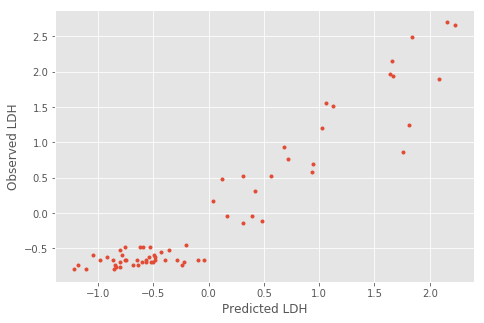

R2Y value = 0.89387271269 .


In [21]:
# Create new Xs
fourPhosX = np.zeros((66,24))
for i in range (0,24):
    index = ind4pProtein[i]-1
    fourPhosX[:,i] = X[:,index]

# Learn and apply the dimension reduction on the train data
fourPhosX_scaled = scale(fourPhosX)
PLS.fit(fourPhosX_scaled, Y48_scaled)
Y48_predicted = PLS.predict(fourPhosX_scaled)

# Plot predicted LDH versus observed LDH
plt.figure(3,figsize=(7.5,5))
plt.plot(Y48_predicted, Y48_scaled,'.')
plt.xlabel('Predicted LDH')
plt.ylabel('Observed LDH')
plt.show()

# Score X and Y48
R2Y = PLS.score(fourPhosX_scaled,Y48_scaled)
print('R2Y value =', R2Y,'.')

Using the final 4 phosphoprotein model, the calculated R2Y was 0.894, and since this value is relatively close to 1, we know that the model is a good predictor of the observed LDH. We can compare this to the R2Y value calculated using all 17 phosphoproteins, which was just slightly higher at 0.923. Thus, it would be fair to say that the model with all phosphoproteins may be slightly more accurate, the final 4 phosphoprotein model is still a valuable prediction method if you want to work with a smaller volume of data. Another way we can determine fitness of the model is the relatively linear relationship between the predicted and observed LDH values, as plotted on the graph. 

R^2, or R2Y, is calculated here as R^2 = 1-(x/y) where x is the sum of the square of the differences between the observed LDH values and the predicted LDH values, and y is the sum of the squares of the observed LDH values.

#### (6) Cosgrove et al. Discusses their method for model validation using leave- one-out cross-validation. Calculate all LDH predictions for leave-one-out cross-validation and calculate the R^2 value for the resulting yfit values. What is the R^2 value? Why do you think it’s important to perform cross-validation?

In [7]:
# Rename LeaveOneOut
loo = LeaveOneOut()

# Initialize zero vectors for training and test sets for both X and Y 
Xtrain = np.zeros((65,102))
Ytrain = np.zeros(65)
Xtest = np.zeros(102)
Ytest = np.zeros(1)
predictions = np.zeros(66) 
count = 0

# Split Xs into training and test sets
for train, test in loo.split(X):
    
    # Create new matrices for training and test data
    Xtrain, Xtest = X_scaled[train], X_scaled[test]
    Ytrain, Ytest = Y48_scaled[train], Y48_scaled[test]
    
    # Learn the dimension reduction on the training data
    PLS.fit(Xtrain, Ytrain)
    
    # Predict Ytest
    Y48_predicted = PLS.predict(Xtest)
    predictions[count] = Y48_predicted
    
    # Add 1 to counter for each new set of training and test data
    count +=1

# Calculate and print R2Y value
num = np.sum((Y48_scaled - scale(predictions))**2)
denom = np.sum((Y48_scaled**2))
R2Y = 1-(num/denom)
print('R2Y value =', R2Y,'.')

R2Y value = 0.84187328868 .


As indicated above, the R^2 value is equal to 0.842 using leave-one-out cross-validation. Performing cross-validation is an important step for ensuring that our model maintains a low test error. Withot cross-validation, we would be fitting out model using all available sample data, and would have no data remaining on which we could test the model. This could easily result in a model that is overfit to our sample data and cannot accurately predict data outside our sample set. 

#### (7) Now, instead of performing LOOCV, let's perform leave-one-cytokine-out cross-validation. That is, one cytokine at a time, leave out all the data for the `NoCyt`, `IL-1`, `LPS`, `TNF`, `IL-6`, or `Mix` conditions.

Hint: Look at `sklearn.model_selection.LeaveOneGroupOut`.

How does this affect your cross-validation? How do the two approaches here differ? When might each be most appropriate?

In [11]:
# Rename LeaveOneGroupOut function
logo = LeaveOneGroupOut()

# Create groups array
groups = np.zeros(66)
for i in range(0,66):
    groups[i]=i%6
    
# Initialize zero vectors for training and test sets for both X and Y 
scores = np.zeros(65)
R2Ys = np.zeros(6) 
predictions = np.zeros(66)
scores = np.zeros(6)
count = 0

for train, test in logo.split(X_scaled, Y48_scaled, groups):
    
    # Create new matrices for training and test data
    Xtrain, Xtest = X_scaled[train], X_scaled[test]
    Ytrain, Ytest = Y48_scaled[train], Y48_scaled[test]

    # Learn the dimension reduction on the training data
    PLS.fit(Xtrain, Ytrain)
    
    # Predict Ytest
    Y48_predicted = PLS.predict(Xtest)
    predictions[test] = np.squeeze(Y48_predicted)
    
    # Add 1 to counter for each new set of training and test data
    count += 1

# Calculate and print R2Y value
num = np.sum((Y48_scaled - scale(predictions))**2)
denom = np.sum((Y48_scaled**2))
R2Y = 1-(num/denom)
print('R2Y value =', R2Y,'.')

R2Y value = 0.858751197771 .


The leave-one-cytokine-out cross-validation method gives us a slightly higher R^2 value than the original leave-one out cross-validation, however, they do not differ greatly. This indicates that they are both valid models for prediction. While the original method would leave out one cytokine/drug combination, this method will leave out one cytokine for all 11 drugs. As such, the second model is a more general approach and is more appropriate if we want to predict LDH values for new cytokines not included in the original set. Conversely, the first model would be more appropriate if we are working with more data dealing with these specific drugs and cytokines from the sample data. 